In [80]:
import pandas as pd
import pickle
import numpy as np
from scipy.stats import pearsonr
from tqdm.notebook import tqdm, tqdm_notebook
import json
import seaborn as sns
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
sns.set()

In [15]:
wmt19_toen = pickle.load(open('../pickles/wmt19_toen_bleurt.pkl', 'rb'))
wmt19_toen.head()

,system,sid,raw_score,score,N,lp,reference,source,output,year,bleurt
27600,DBMS-KU-KKEN.6726,751,2.0,-1.463163,1,kk-en,Three professional boxers from Kazakhstan will...,Қазақстандық үш кәсіпқой боксшы Мәскеуде жекпе...,three кәсіпқой қазақстандық боксшы өткізеді же...,2019,-1.628130
27601,CUNI-T2T-transfer-kken.6436,751,92.5,0.820222,2,kk-en,Three professional boxers from Kazakhstan will...,Қазақстандық үш кәсіпқой боксшы Мәскеуде жекпе...,Three Kazakh professional boxers will fight in...,2019,0.582905
27602,UMD.6736,751,70.0,-0.203777,1,kk-en,Three professional boxers from Kazakhstan will...,Қазақстандық үш кәсіпқой боксшы Мәскеуде жекпе...,Kazakhstan's boxer's team will compete for the...,2019,-0.418227
27603,NICT.6770,751,60.5,0.408585,2,kk-en,Three professional boxers from Kazakhstan will...,Қазақстандық үш кәсіпқой боксшы Мәскеуде жекпе...,Three professional boxers of Kazakhstan will c...,2019,0.500814
27604,online-G.0,751,92.5,0.820222,2,kk-en,Three professional boxers from Kazakhstan will...,Қазақстандық үш кәсіпқой боксшы Мәскеуде жекпе...,Three Kazakh professional boxers will fight in...,2019,0.582905


In [101]:
scale = True
x = []
y = []
hue = []

for lp, lp_group in wmt19_toen.groupby(['lp']):
    means = lp_group.groupby(['system']).mean()
    
    reg = sm.OLS(means['score'], sm.add_constant(means['bleurt']))
    res = reg.fit()
    means['adjusted_bleurt'] = res.predict(sm.add_constant(means['bleurt']))
    se_sys = np.square(means['score'] - means['adjusted_bleurt'])
    
    for i, sys_group in lp_group.groupby(['system']):
        group = sys_group.copy()
        reg = sm.OLS(group['score'], sm.add_constant(group['bleurt']))
        res = reg.fit()
        group['adjusted_bleurt'] = res.predict(sm.add_constant(group['bleurt']))
        mse_seg = np.mean(np.square(group['score'] - group['adjusted_bleurt']))

        x.append(mse_seg)
        y.append(se_sys[i])
        hue.append(lp)

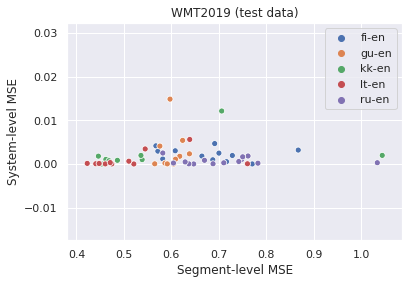

In [102]:
plt.xlabel('Segment-level MSE')
plt.ylabel('System-level MSE')

# filter out 2 points
fx = [i for i, j in zip(x,y) if j < 0.1 and i < 1400]
fy = [j for i, j in zip(x,y) if j < 0.1 and i < 1400]
hue = [k for i, j, k in zip(x,y, hue) if j < 0.1 and i < 1400]
plt.title('WMT2019 (test data)')
sns.scatterplot(x=fx, y=fy, hue=hue)

In [93]:
wmt_toen = pickle.load(open('../pickles/wmt_toen_bleurt.pkl', 'rb'))
wmt_toen.head()

,system,sid,raw_score,score,N,lp,reference,source,output,year,system_full,bleurt
0,online-B,1673,63.0,-0.001670,2,cs-en,Ten statements by Albert Einstein that enriche...,"Desatero výroků Alberta Einsteina, které oboha...",Ten Commandments statements of Albert Einstein...,2016,NaN,-0.167327
1,uedin-nmt,1673,62.0,-0.400967,1,cs-en,Ten statements by Albert Einstein that enriche...,"Desatero výroků Alberta Einsteina, které oboha...","The Ten Commandments of Albert Einstein, which...",2016,NaN,-0.051850
2,PJATK,1673,89.0,1.134907,1,cs-en,Ten statements by Albert Einstein that enriche...,"Desatero výroků Alberta Einsteina, které oboha...","The Ten sayings, Albert Einstein, which enrich...",2016,NaN,0.099259
3,jhu-pbmt,1673,77.0,0.476686,2,cs-en,Ten statements by Albert Einstein that enriche...,"Desatero výroků Alberta Einsteina, které oboha...","The Ten utterances of Albert Einstein, which e...",2016,NaN,0.384091
4,cu-mergedtrees,1673,88.0,0.740644,1,cs-en,Ten statements by Albert Einstein that enriche...,"Desatero výroků Alberta Einsteina, které oboha...","The ten Albert Einstein, enriching world.\n",2016,NaN,-0.270378


In [112]:
scale = True
x = []
y = []
hue = []

for (year, lp), yl_group in wmt_toen.groupby(['year', 'lp']):
    if year == 2019:
        continue
        
    means = yl_group.groupby(['system']).mean()
    
    reg = sm.OLS(means['score'], sm.add_constant(means['bleurt']))
    res = reg.fit()
    means['adjusted_bleurt'] = res.predict(sm.add_constant(means['bleurt']))
    se_sys = np.square(means['score'] - means['adjusted_bleurt'])
    
    for i, sys_group in yl_group.groupby(['system']):
        group = sys_group.copy()
        reg = sm.OLS(group['score'], sm.add_constant(group['bleurt']))
        res = reg.fit()
        group['adjusted_bleurt'] = res.predict(sm.add_constant(group['bleurt']))
        mse_seg = np.mean(np.square(group['score'] - group['adjusted_bleurt']))

        x.append(mse_seg)
        y.append(se_sys[i])
        hue.append(str(year))

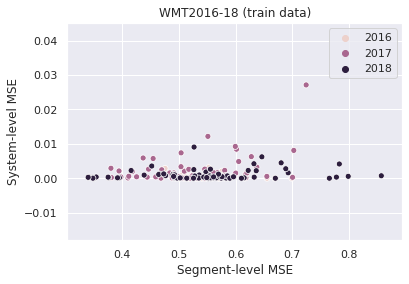

In [113]:
plt.xlabel('Segment-level MSE')
plt.ylabel('System-level MSE')

# filter out 2 points
fx = [i for i, j in zip(x,y) if j < 0.1 and i < 1400]
fy = [j for i, j in zip(x,y) if j < 0.1 and i < 1400]
plt.title('WMT2016-18 (train data)')
sns.scatterplot(x=x, y=y, hue=hue)